# CarND - Behavorial Cloning - Project3


#### File structure

- CarND-BehavorialCloning/ ---- Root folder
    - data/ ----------------------- Training image data.
        - IMG/ ------------------ Center, left and right images (Not included).
        - driving_log.csv ------- Log for name of the images with steering angle, throttle, break and speed.
    - drive.py -------------------- Connects to Udacity simulator and predicts with the model, images from simulator.
    - model.py ------------------ The NN model. Based on Nvidia's blog.* Here you can also see the loading of the data with some augmentation
    - model.json ---------------- Json representation of the model
    - model.h5 ------------------ Saved weights from the model training. 
    - BehavorialCloning.ipyn -- Jupyter Notebook. Documentation for this project.(This notebook)
    

*https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/



In [1]:
# Imports
import os, csv, json, math, cv2
import numpy as np
import tensorflow as tf
tf.python.control_flow_ops = tf

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.core import Lambda
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.utils import np_utils

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Functions

# Generate batch to train with augmentation
def getBatch(data, batch_size):
    steeringIndex = 3
    while 1:    
        batch_x = np.zeros((batch_size, 66, 200, 3))
        batch_y = np.zeros(batch_size)
        i = 0
        while i < batch_size:
            useImg = False
            # Get random index in data and set steering value accordingly
            rint = np.random.randint(len(data)-1)
            steeringValue = float(data[rint][steeringIndex])         
            
            # Check if steering is approx straight driving - We dont want to take them all...
            if -0.1 <= steeringValue <= 0.1 and np.random.randint(10) == 1:
                useImg = True

            # All images which are not as near 0.0 we will use
            else:
                useImg = True
            
            if useImg:              
                # Get random type of image. center, left or right image
                rtype = np.random.randint(3)
                
                if rtype == 1: # Left image add offset
                    steeringValue += .2
                if rtype == 2: # Right image add offset
                    steeringValue -= .2 
                    
                batch_y[i] = steeringValue
                batch_x[i] = resizeImg(cropTopBot(getImageToBatch(data[rint][rtype])))
                i += 1
                
                # Add random flip by axes images. Approx 1 of 5
                if np.random.randint(5) == 1:
                    batch_x[i], batch_y[i] = flip(batch_x[i], batch_y[i])             

        yield batch_x, batch_y
        
        
# Flip images by axis and steering angle
def flip(image, angle):
    flippedImg = cv2.flip(image,1)
    flippedAngle = angle * (-1)
    return flippedImg, flippedAngle

# Normalize images
def normalize(image):
    return image / 255.0 - 0.5

# Load image from path to np array. CV2 loads image in BGR but we change it to RGB as well.
def getImageToBatch(imgpath):
    img = cv2.imread(imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Crop 60pixels of the top of the image as they are not needed for driving..
# and we take 20px from bottom to get rid of the car from the image
def cropTopBot(img):
    return img[60:140, 0:320] # Crop from x, y, w, h 

# Resize the image to fit our model input shape (66,200,3)
def resizeImg(img):
    return cv2.resize(img, (200,66))

# Reads the driving log csv file 
def prepareDataFromCSV(path):
    data = []
    with open(path) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            data.append(
                [
                    os.getcwd() + '/data/' + row['center'], 
                    os.getcwd() + '/data/' + row['left'], 
                    os.getcwd() + '/data/' + row['right'], 
                    row['steering']
                ])
    return data


In [3]:
# The model

def getCNN():
    
    model = Sequential()

    # Noramlization
    model.add(Lambda(normalize, input_shape=(66, 200, 3)))

    # Layer 1 - Convolutional
    model.add(Convolution2D(24, 5, 5, border_mode='valid', subsample=(2,2)))
    model.add(Activation('relu'))

    # Layer 2 - Convolutional
    model.add(Convolution2D(36, 5, 5, border_mode='valid', subsample=(2,2)))
    model.add(Activation('relu'))

    # Layer 3 - Convolutional
    model.add(Convolution2D(48, 5, 5, border_mode='valid', subsample=(2,2)))
    model.add(Activation('relu'))

    # Layer 4 - Convolutional
    model.add(Convolution2D(64, 3, 3, border_mode='valid', subsample=(1,1)))
    model.add(Activation('relu'))

    # Layer 4 - Convolutional
    model.add(Convolution2D(64, 3, 3, border_mode='valid', subsample=(1,1)))
    model.add(Activation('relu'))

    # Layer 5 Flatten
    model.add(Flatten())

    # Layer 6 - Fully-connected
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    # Layer 7 - Fully-connected
    model.add(Dense(50))
    model.add(Activation('relu'))

    # Layer 8 - Fully-connected
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    
    # Layer 9 - Fully-connected
    model.add(Dense(1))
    
    return model


In [ ]:
# DO NOT RUN IN JUPYTER NOTEBOOK
# Main function that load the model, compiles it and starts training. Then we save the model and weights
def main():
    path = '/data/driving_log.csv'
    training_data = prepareDataFromCSV(os.getcwd() + path)
    batch_size = 128
    samples_per_epoch = batch_size * 320
    nb_epoch = 10
    print(" Training data from csv: {}".format(path))
    print(" Batch size: {} \n Number of epochs: {} \n Samples per epoch {}"
        .format(batch_size, nb_epoch, samples_per_epoch))

    # Get model
    model = getCNN()
    # Compile the model with adam optimizer
    adam = Adam(lr = 0.001)
    model.compile(optimizer=adam, loss="mse")
    # Start fit the model
    history = model.fit_generator(
        getBatch(training_data, batch_size), 
        samples_per_epoch=samples_per_epoch,
        nb_epoch=nb_epoch)
    
    # Save model.
    json_string = model.to_json()
    with open('model.json', 'w') as outfile:
        json.dump(json_string, outfile)
    # Save weights.
    model.save_weights('model.h5')

    print("Training finished... Model and weights saved!")


In [4]:
# Run this to view the model summary
model = getCNN()
# Compile the model with adam optimizer
adam = Adam(lr = 0.001)
model.compile(optimizer=adam, loss="mse")
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 66, 200, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 31, 98, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 47, 36)    21636       activation_1[0][0]               
___________________________________________________________________________________________

## The model
Built on: 
https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/

<img src="files/data/cnn-architecture.png">

Some text here about the model...


## The training

Some text about training the model. Parameters and stuff
<img src="files/data/trainingepochs.png">



## The data

Some text about the data and data augmentation

This is an example of unchanged images in our set
Steering angle: 0.1287396 


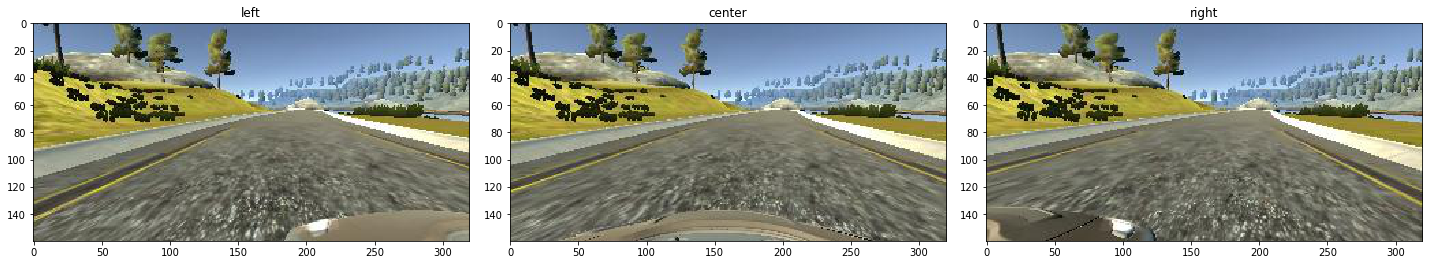

In [12]:
# Example of Center, Left and Right images.
path = '/data/driving_log.csv'
training_data = prepareDataFromCSV(os.getcwd() + path)
imgIndex = 2351
center = getImageToBatch(training_data[imgIndex][0])
left = getImageToBatch(training_data[imgIndex][1])
right = getImageToBatch(training_data[imgIndex][2])
steering_angle = float(training_data[imgIndex][3])


print("This is an example of unchanged images in our set")
print('Steering angle: {} '.format(steering_angle))
plt.figure(figsize=(20,20));
plt.subplot(1,3,1, title='left')
plt.imshow(left)
plt.subplot(1,3,2, title='center')
plt.imshow(center)
plt.subplot(1,3,3, title='right')
plt.imshow(right)
plt.tight_layout()

We than crop the top of the images by 60px as that has nothing to do with the model
We also crop 20px from bottom to get rid of the car
Steering angle: 0.1287396 


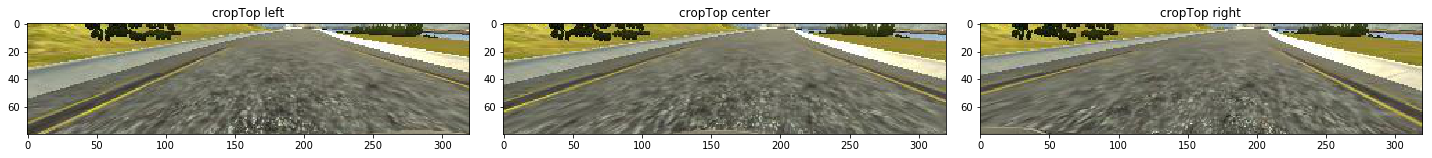

In [13]:
print("We than crop the top of the images by 60px as that has nothing to do with the model")
print("We also crop 20px from bottom to get rid of the car")
print('Steering angle: {} '.format(steering_angle))
plt.figure(figsize=(20,20));
plt.subplot(1,3,1, title='cropTop left')
plt.imshow(cropTopBot(left))
plt.subplot(1,3,2, title='cropTop center')
plt.imshow(cropTopBot(center))
plt.subplot(1,3,3, title='cropTop right')
plt.imshow(cropTopBot(right))
plt.tight_layout()

Than we resize the images to fit our model with shape (66,200,3)
Steering angle: 0.1287396 


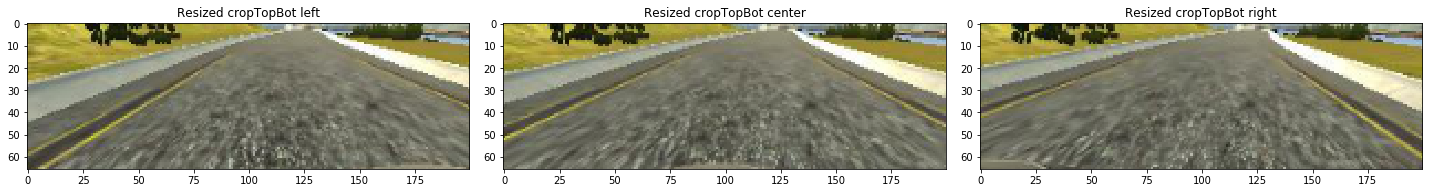

In [14]:
print("Than we resize the images to fit our model with shape (66,200,3)")
print('Steering angle: {} '.format(steering_angle))
plt.figure(figsize=(20,20));
plt.subplot(1,3,1, title='Resized cropTopBot left')
plt.imshow(resizeImg(cropTopBot(left)))
plt.subplot(1,3,2, title='Resized cropTopBot center')
plt.imshow(resizeImg(cropTopBot(center)))
plt.subplot(1,3,3, title='Resized cropTopBot right')
plt.imshow(resizeImg(cropTopBot(right)))
plt.tight_layout()

Than we resize the images to fit our model with shape (66,200,3)
Steering angle: -0.1287396 


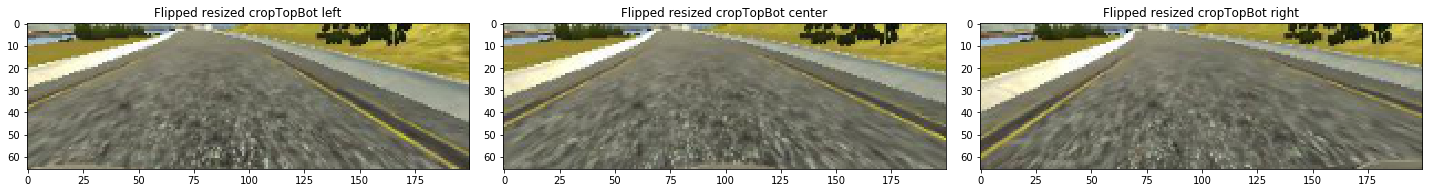

In [15]:
# Modify flip to plot
# Flip images by axis and steering angle
def flipImage(image):
    return cv2.flip(image,1)
def flipAngle(angle):    
    return angle * (-1)

print("Than we resize the images to fit our model with shape (66,200,3)")
print('Steering angle: {} '.format(flipAngle(steering_angle)))
plt.figure(figsize=(20,20));
plt.subplot(1,3,1, title='Flipped resized cropTopBot left')
plt.imshow(flipImage(resizeImg(cropTopBot(left))))
plt.subplot(1,3,2, title='Flipped resized cropTopBot center')
plt.imshow(flipImage(resizeImg(cropTopBot(center))))
plt.subplot(1,3,3, title='Flipped resized cropTopBot right')
plt.imshow(flipImage(resizeImg(cropTopBot(right))))
plt.tight_layout()



Steering angles in dataset: 8036


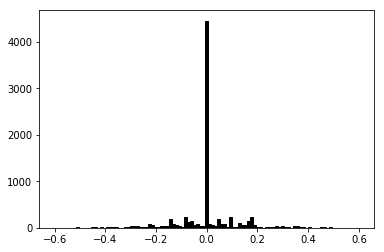

Like we can see in this histogram that the amount of driving straight images is significantly more than other images.


In [16]:
all_angles_in_set = []
for i in range(len(training_data)):
    all_angles_in_set.append(float(training_data[i][3]))
    
print("Steering angles in dataset: {}".format(len(all_angles_in_set)))
plt.hist(all_angles_in_set, range=(-.6, 0.6), bins=101, fc='k', ec='k')
plt.show()
print('Like we can see in this histogram that the amount of driving straight images is significantly more than other images.')

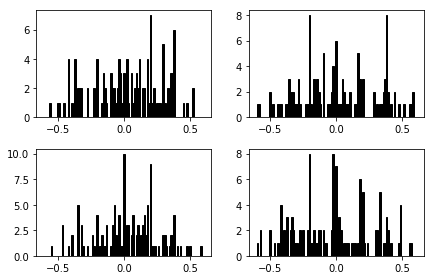

In [29]:
# This function does the same as the one generating batches for training
# Modified to show histograms of steering angles
def getBatch(data, batch_size):
    steeringIndex = 3
    while 1:    
        batch_x = np.zeros((batch_size, 66, 200, 3))
        batch_y = np.zeros(batch_size)
        i = 0
        while i < batch_size:
            useImg = False
            # Get random index in data and set steering value accordingly
            rint = np.random.randint(len(data)-1)
            steeringValue = float(data[rint][steeringIndex])         
            
            # Check if steering is approx straight driving - We dont want to take them all...
            if -0.10 <= steeringValue <= 0.1: 
                if np.random.randint(10) == 1:
                    useImg = True

            # All images which are not as near 0.0 we will use
            else:
                useImg = True
            
            if useImg:              
                # Get random type of image. center, left or right image
                rtype = np.random.randint(3)
                
                if rtype == 1: # Left image add offset
                    steeringValue += .2
                if rtype == 2: # Right image add offset
                    steeringValue -= .2 
                    
                batch_y[i] = steeringValue
                batch_x[i] = resizeImg(cropTopBot(getImageToBatch(data[rint][rtype])))
                
                # Add random flip by axes images. Approx 1 of 5
                if np.random.randint(5) == 1:
                    batch_x[i], batch_y[i] = flip(batch_x[i], batch_y[i])

                # As we used the image i will increse by one
                i += 1          

        return batch_y

batch_size = 128
batches = []
for x in range(4):
    batches.append(getBatch(training_data, batch_size))

f,a = plt.subplots(2,2)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(batches[idx], range=(-.6, 0.6), bins=101, fc='k', ec='k')
plt.tight_layout()


## Summary